This notebook demonstrates how to read in 2D KPF files, do basic image manipulations, and measure photometry.  It was designed to measure a dark-current-like signal from the ion pumps.
# Import Packages

In [1]:
#from astropy.io import fits
from kpfpipe.models.level0 import KPF0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from astropy.table import Table
from modules.Utils.kpf_parse import get_datecode
%matplotlib inline

# Define parameters
Different example exposures can be selected below.

In [2]:
# Parameters
ccd = ['green', 'red'] # ['green'] or ['red'] or ['green', 'red']
data_dir = '/data/2D/'
out_dir = 'ion_pump_plots/'
#ObsID = 'KP.20230311.63253.52' # dark frame
#ObsID = 'KP.20230312.03990.62' # dark frame
#ObsID = 'KP.20230308.32335.99' # dark frame - before warmup
#ObsID = 'KP.20230308.32335.99' # dark frame
#ObsID = 'KP.20230314.03992.75' # dark frame just as ion pump was turned on after warmup
#ObsID = 'KP.20230314.07774.61' # dark frame next - about 1 hr after ion pump turned on
#ObsID = 'KP.20230314.11989.91' # dark frame next - about 2 hr after ion pump turned on
#ObsID = 'KP.20230317.07770.97' # dark frame with ion pump currents recorded
#ObsID = 'KP.20230311.29791.13' # bias frame
#ObsID = 'KP.20230308.29360.64' # bias frame
ObsID = 'KP.20240401.61769.07' # dark frame about two months after first Service Mission

do_print    = False
do_display  = True
do_save_png = False

# Read 2D image and telemetry

In [3]:
D2_file = data_dir + get_datecode(ObsID) + '/' + ObsID + '_2D.fits'
D2 = KPF0.from_fits(D2_file, data_type='KPF')
exptime = D2.header['PRIMARY']['EXPTIME']
#D2.info()

# Read telemetry
df_telemetry = D2['TELEMETRY']
df_telemetry.set_index("keyword", inplace=True)
#df_telemetry = Table.read(D2_file, format='fits', hdu=11).to_pandas() # need to refer to HDU by name
num_columns = ['average', 'stddev', 'min', 'max']
for column in df_telemetry:
    df_telemetry[column] = df_telemetry[column].str.decode('utf-8')
    df_telemetry = df_telemetry.replace('-nan', 0)# replace nan with 0
    if column in num_columns:
        df_telemetry[column] = pd.to_numeric(df_telemetry[column], downcast="float")
    else:
        df_telemetry[column] = df_telemetry[column].astype(str)
#df_telemetry.set_index("keyword", inplace=True)

# Define apertures, measure photometry, and plot CCD images

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:92: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:93: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


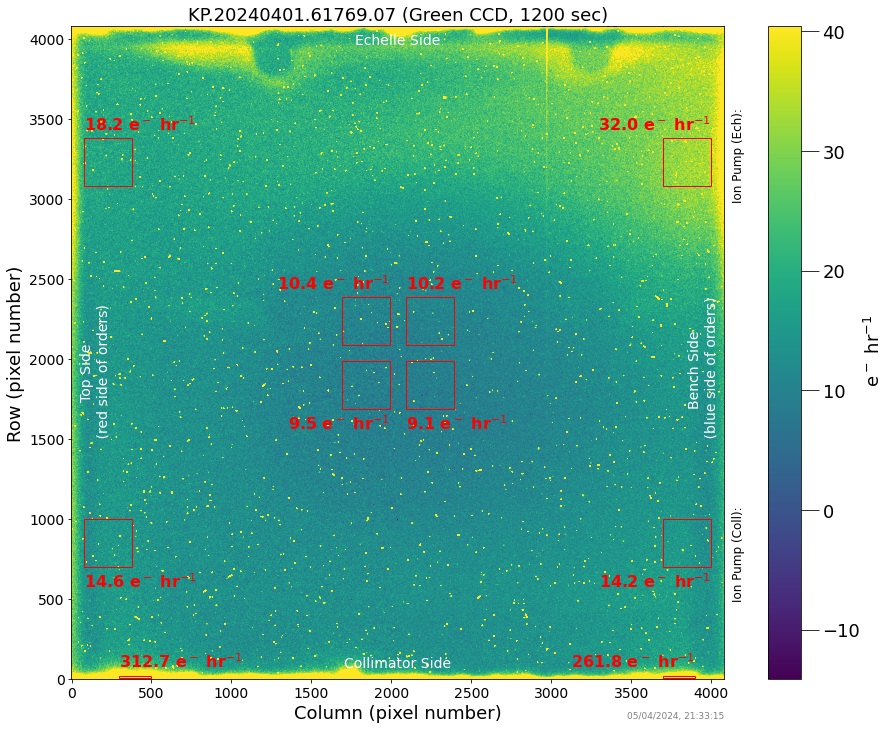

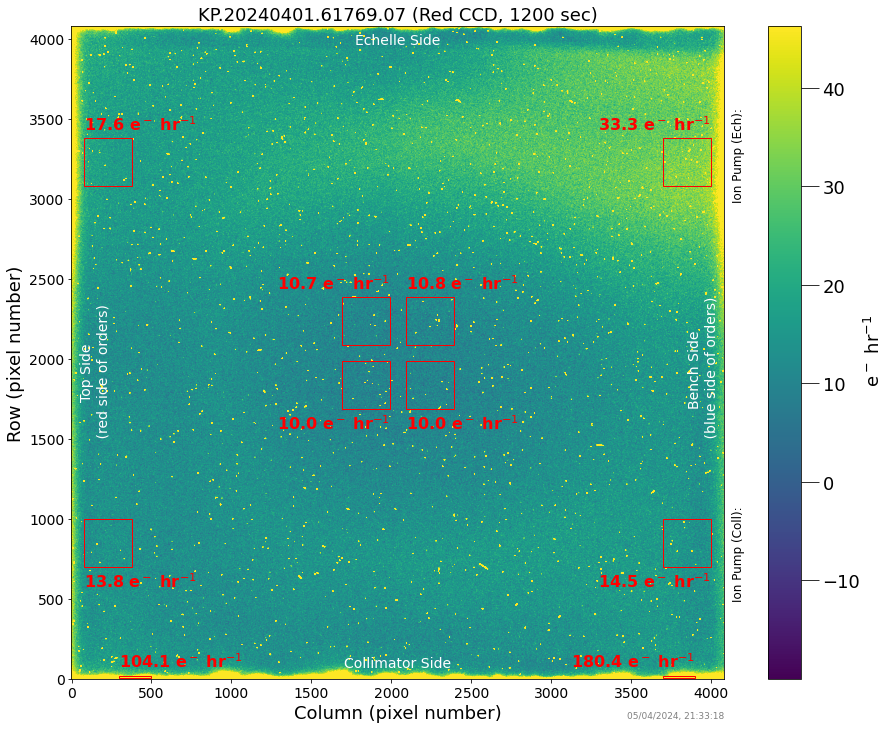

In [4]:
for c in ccd:
    if c == 'green':
        frame = np.array(D2['GREEN_CCD'].data)
        coll_pressure_torr = df_telemetry.loc['kpfgreen.COL_PRESS', 'average']
        ech_pressure_torr  = df_telemetry.loc['kpfgreen.ECH_PRESS', 'average']
        coll_current_a     = df_telemetry.loc['kpfgreen.COL_CURR',  'average']
        ech_current_a      = df_telemetry.loc['kpfgreen.ECH_CURR',  'average']
        png_fn = out_dir + ObsID + '_green.png'
    elif c == 'red':
        frame = np.array(D2['RED_CCD'].data)
        coll_pressure_torr = df_telemetry.loc['kpfred.COL_PRESS', 'average']
        ech_pressure_torr  = df_telemetry.loc['kpfred.ECH_PRESS', 'average']
        coll_current_a     = df_telemetry.loc['kpfred.COL_CURR',  'average']
        ech_current_a      = df_telemetry.loc['kpfred.ECH_CURR',  'average']
        png_fn = out_dir + ObsID + '_red.png'

    # Dark frame
    if exptime > 0:
        exptype = 'dark'
        timelabel = ' e$^-$ hr$^{-1}$'
        frame *= (3600./exptime)  # convert to e- per hour
    # Bias frame
    else:
        exptype = 'bias'
        timelabel = ' e$^-$'

    # Define regions
    reg = {'ref1': {'name': 'Reference Region 1',         'x1': 1690, 'x2': 1990, 'y1': 1690, 'y2': 1990, 'short':'ref1', 'med_elec':0, 'label':''},
           'ref2': {'name': 'Reference Region 2',         'x1': 1690, 'x2': 1990, 'y1': 2090, 'y2': 2390, 'short':'ref2', 'med_elec':0, 'label':''},
           'ref3': {'name': 'Reference Region 3',         'x1': 2090, 'x2': 2390, 'y1': 1690, 'y2': 1990, 'short':'ref3', 'med_elec':0, 'label':''},
           'ref4': {'name': 'Reference Region 4',         'x1': 2090, 'x2': 2390, 'y1': 2090, 'y2': 2390, 'short':'ref4', 'med_elec':0, 'label':''},
           'ref5': {'name': 'Reference Region 5',         'x1':   80, 'x2':  380, 'y1':  700, 'y2': 1000, 'short':'ref5', 'med_elec':0, 'label':''},
           'ref6': {'name': 'Reference Region 6',         'x1':   80, 'x2':  380, 'y1': 3080, 'y2': 3380, 'short':'ref6', 'med_elec':0, 'label':''},
           'amp1': {'name': 'Amplifier Region 1',         'x1':  300, 'x2':  500, 'y1':    5, 'y2':   20, 'short':'amp1', 'med_elec':0, 'label':''},
           'amp2': {'name': 'Amplifier Region 2',         'x1': 3700, 'x2': 3900, 'y1':    5, 'y2':   20, 'short':'amp2', 'med_elec':0, 'label':''},
           'coll': {'name': 'Ion Pump (Collimator side)', 'x1': 3700, 'x2': 4000, 'y1':  700, 'y2': 1000, 'short':'coll', 'med_elec':0, 'label':''},
           'ech':  {'name': 'Ion Pump (Echelle side)',    'x1': 3700, 'x2': 4000, 'y1': 3080, 'y2': 3380, 'short':'ech',  'med_elec':0, 'label':''}
          }
    for r in reg.keys():
        current_region = frame[reg[r]['y1']:reg[r]['y2'],reg[r]['x1']:reg[r]['x2']]
        reg[r]['med_elec'] = np.median(current_region)
        if do_print:
            print(reg[r]['name'] + ': ' + str(np.round(reg[r]['med_elec'],1)) + ' e- per hour') 
    if do_print:
        print('Ion Pump pressure (Torr) - Collimator side: ' + f'{coll_pressure_torr:.1f}')
        print('Ion Pump pressure (Torr) - Echelle side: '    + f'{ech_pressure_torr:.1f}')
        print('Ion Pump current (A) - Collimator side: '     + f'{coll_current_a:.1f}')
        print('Ion Pump current (A) - Echelle side: '        + f'{ech_current_a:.1f}')

    # Plot
    if do_display or do_save_png:
        from matplotlib.patches import Rectangle
        plt.figure(figsize=(16, 12))
        plt.imshow(frame, 
                   cmap='viridis', 
                   origin='lower', 
                   vmin=np.percentile(frame[300:3780,0:4080],5), 
                   vmax=np.percentile(frame[300:3780,0:4080],90)
                  )
        for r in reg.keys():
            plt.gca().add_patch(Rectangle((reg[r]['x1'],reg[r]['y1']),reg[r]['x2']-reg[r]['x1'],reg[r]['y2']-reg[r]['y1'],linewidth=1,edgecolor='r',facecolor='none')) 
            plt.text(((reg[r]['short'] == 'ref3') or 
                      (reg[r]['short'] == 'ref4') or 
                      (reg[r]['short'] == 'ref5') or
                      (reg[r]['short'] == 'ref6') or 
                      (reg[r]['short'] == 'amp1'))*(reg[r]['x1'])+
                     ((reg[r]['short'] == 'ref1') or 
                      (reg[r]['short'] == 'ref2') or 
                      (reg[r]['short'] == 'ech')  or 
                      (reg[r]['short'] == 'coll') or 
                      (reg[r]['short'] == 'amp2'))*(reg[r]['x2']),
                     (((reg[r]['y1'] < 2080) and (reg[r]['y1'] > 100))*(reg[r]['y1']-30)+
                      ((reg[r]['y1'] > 2080) or  (reg[r]['y1'] < 100))*(reg[r]['y2']+30)), 
                     str(np.round(reg[r]['med_elec'],1)) + timelabel, 
                     size=16,
                     weight='bold',
                     color='r', 
                     ha=(((reg[r]['short'] == 'ref3') or 
                          (reg[r]['short'] == 'ref4') or 
                          (reg[r]['short'] == 'ref5') or
                          (reg[r]['short'] == 'ref6') or 
                          (reg[r]['short'] == 'amp1'))*('left')+
                         ((reg[r]['short'] == 'ref1') or 
                          (reg[r]['short'] == 'ref2') or 
                          (reg[r]['short'] == 'ech')  or 
                          (reg[r]['short'] == 'coll') or 
                          (reg[r]['short'] == 'amp2'))*('right')),
                     va=(((reg[r]['y1'] < 2080) and (reg[r]['y1'] > 100))*('top')+
                         ((reg[r]['y1'] > 2080) or (reg[r]['y1'] < 100))*('bottom'))
                    )
        now = datetime.now()
        coll_text = 'Ion Pump (Coll): \n' + (f'{coll_pressure_torr:.1f}' + ' Torr, ' + f'{coll_current_a*1e6:.1f}' + ' $\mu$A')*(coll_pressure_torr > 1e-9) + ('Off')*(coll_pressure_torr < 1e-9)
        ech_text  = 'Ion Pump (Ech): \n'  + (f'{ech_pressure_torr:.1f}'  + ' Torr, ' + f'{ech_current_a*1e6:.1f}'  + ' $\mu$A')*(ech_pressure_torr  > 1e-9) + ('Off')*(ech_pressure_torr < 1e-9)
        plt.text(4080, -250, now.strftime("%m/%d/%Y, %H:%M:%S"), size=9, ha='right', color='gray')
        plt.text(4220,  500, coll_text, size=12, rotation=90, ha='center')
        plt.text(4220, 3000, ech_text,  size=12, rotation=90, ha='center')
        plt.text(3950, 1500, 'Bench Side\n (blue side of orders)', size=14, rotation=90, ha='center', color='white')
        plt.text( 150, 1500, 'Top Side\n (red side of orders)',    size=14, rotation=90, ha='center', color='white')
        plt.text(2040,   70, 'Collimator Side',                    size=14, rotation= 0, ha='center', color='white')
        plt.text(2040, 3970, 'Echelle Side',                       size=14, rotation= 0, ha='center', color='white')
        cbar = plt.colorbar()
        cbar.set_label(timelabel, fontsize=18)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.tick_params(size=18)
        plt.title(ObsID + ' (' + (c == 'green')*('Green CCD') + (c == 'red')*('Red CCD') + ', ' + str(round(exptime)) + ' sec)', fontsize=18)
        plt.xlabel('Column (pixel number)', fontsize=18)
        plt.ylabel('Row (pixel number)', fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(False)
        if do_save_png:
            plt.savefig(png_fn, facecolor='w')
        if do_display:
            plt.show()

Some notes about the above images:
* There are apertures for the two ion pumps per CCD.  Two apertures placed symmetrically on the left edge of the CCDs are for reference.  Also for reference are the four apertures in the middle of each chip, one per quadrant (which have separate amplifiers, at least on the green CCD).
* Cosmic rays are not being subtracted, but should.